In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from celluloid import Camera
import numpy as np
import random

In [2]:
import pymunk
from pymunk.vec2d import Vec2d
import pymunk.matplotlib_util

Loading chipmunk for Darwin (64bit) [/anaconda3/lib/python3.6/site-packages/pymunk/libchipmunk.dylib]


In [4]:
def setup_space(gx, gy, damping):
    space = pymunk.Space()
    space.gravity = gx, gy
    space.damping = damping
    return space

In [5]:
def setup_walls(space, px, py, offset, elasts, width):
    body = pymunk.Body(body_type = pymunk.Body.STATIC) # 1
    body.position = (px, py)
    offset = offset
    l1 = pymunk.Segment(body, (-offset, offset), (offset, offset), width) # 2
    l2 = pymunk.Segment(body, (-offset, offset), (-offset, -offset), width)
    l3 = pymunk.Segment(body, (-offset, -offset), (offset, -offset), width)
    l4 = pymunk.Segment(body, (offset, offset), (offset, -offset), width)
    static_lines = [l1,l2,l3,l4]
    for l_idx, line in enumerate(static_lines):
        line.elasticity = elasts[l_idx]
        line.friction = 0
    space.add(static_lines) # 3
    return static_lines

In [131]:
def setup_balls(space, px, py, offset, masses, radiuses, elasts):
    width = offset*2
    height = offset*2
    balls = [ ]
    n_balls = len(radiuses)
    step = 250//n_balls + 1
    for b_idx, x in enumerate(range(-50,200,step)):
        x += width / 2
        offset_y = height
        mass = masses[b_idx]
        radius = radiuses[b_idx]
        moment = pymunk.moment_for_circle(mass, 0, radius, (0,0))
        body = pymunk.Body(mass, moment)
        body.position = x, -125+offset_y
        body.start_position = Vec2d(body.position)
        shape = pymunk.Circle(body, radius, (0,0))
        shape.elasticity = elasts[b_idx]
        space.add(body, shape)
        balls.append(body)
    #pj = pymunk.PinJoint(balls[0],balls[1], (0, 0), (0,0))
    #space.add(pj)
    #pj = pymunk.PinJoint(balls[1],balls[2], (0, 0), (0,0))
    #space.add(pj)
    return balls

In [132]:
def get_attributes(shape):
    x1, x2, y1, y2 = shape.bb.left, shape.bb.right, shape.bb.bottom, shape.bb.top
    body_type = shape.body.body_type
    if isinstance(shape, pymunk.shapes.Segment):
        shape_type = 0
    elif isinstance(shape, pymunk.shapes.Circle):
        shape_type = 1
    mass = shape.body.mass
    elasticity = shape.elasticity
    return [x1, y1, x2, y2, body_type, shape_type, mass, elasticity]

In [147]:
def initialize_params(n_balls = 5):
    gx, gy = np.random.normal()*1000, np.random.normal()*1000
    offset = np.random.choice([200,225,250,275])
    damping = np.random.rand()
    wall_elasts = np.clip(np.random.rand(4)+0.5, a_min=0.5, a_max=1)
    ball_elasts = np.clip(np.random.rand(n_balls)+0.5, a_min=0.5, a_max=1)
    radiuses = np.clip(np.random.rand(n_balls)*100, a_min=30, a_max=50)
    masses = np.clip(np.random.rand(n_balls)*40, a_min=10, a_max=40)
    params = {'gx': gx, 'gy': gy,'offset' : offset,
              'damping': damping, 'wall_elasts': wall_elasts,
              'masses': masses,'ball_elasts': ball_elasts, 'radiuses': radiuses}
    return params

In [249]:
def run_simulation(params):
    fig, ax = plt.subplots()
    plt.axis('off')
    camera = Camera(fig)
    px, py = 300, 300
    buffer = 15
    side = params["offset"] + buffer
    width = 2
    ax.set_xlim((px-side-10, px+side+10))
    ax.set_ylim((py-side-10, py+side+10))
    ax.set_aspect("equal")
    # creating objects
    space = setup_space(params["gx"], params["gy"], params["damping"])
    lines = setup_walls(space, px, py, side, params["wall_elasts"], width)
    balls = setup_balls(space, px, py, params["offset"], params["masses"], 
                        params["radiuses"], params["ball_elasts"])
    for shape in space.shapes:
        if shape.body.body_type == 0:
            fx, fy = np.random.normal(size=2)
            scale = np.random.rand()*100000
            shape.body.apply_impulse_at_local_point((fx*scale,fy*scale))
    # simulation
    total_steps = 80
    o = pymunk.matplotlib_util.DrawOptions(ax)
    attributes = np.zeros((total_steps+2, len(space.shapes), 8))
    for i in range(total_steps+2):
        for x in range(10):
            space.step(1/50/10/2)
        for s_idx, shape in enumerate(space.shapes):
            attributes[i, s_idx] = get_attributes(shape) 
        space.debug_draw(o)
        camera.snap()
    attributes[np.isposinf(attributes)] = 1e+8
    speed = np.diff(attributes[:,:,:2], axis=0)
    attr_spd = np.concatenate((attributes[1:],speed), axis=-1)
    X = attr_spd[:-1]
    y = attr_spd[1:,:, -2:]
    anim = camera.animate()
    return X, y, anim

In [250]:
params = initialize_params(2)

In [251]:
params

{'gx': -1031.213782279246,
 'gy': 1078.201954533565,
 'offset': 250,
 'damping': 0.6422309337301888,
 'wall_elasts': array([1.        , 0.53306215, 1.        , 0.6675268 ]),
 'masses': array([32.42223425, 24.45380953]),
 'ball_elasts': array([1.       , 0.9182993]),
 'radiuses': array([50., 50.])}

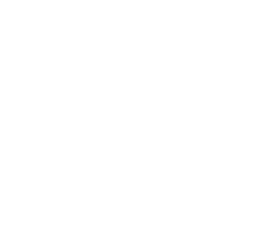

In [257]:
X, y, anim = run_simulation(params)

In [258]:
HTML(anim.to_html5_video())